In [1]:
import numpy as np
import pandas as pd
import os
import matplotlib.pyplot as pltç
import json

In [97]:
model = "resnet18_pspnet_unet"
data_augmentation = "combination"
optimizer = "adam"
criterion = "bce_dice_border_ce"
criterion_weights = "0.5,0.2,0.2,0.2,0.5"
lr = "0.001"
dataset = "mnms"
normalization = "reescale"
train_vendor = "B"
test_vendor = "A"
scheduler = "constant"

args = {"model":model, "Data Augmentation": data_augmentation, "Optimizer":optimizer, "Criterion":criterion,
       "Criterion Weights":criterion_weights, "Learning Rate": lr, "Dataset": dataset, 
        "Normalization":normalization, "Train Vendor": train_vendor, "Test Vendor":test_vendor, 
       "Scheduler":scheduler}

In [98]:
parent_path = "../results/{}/{}/{}/{}_weights{}/normalization_{}/foldBy_vendor/datafold{}_foldtest{}_da{}_scheduler_{}_lr{}".format(model, dataset, optimizer, criterion, criterion_weights, normalization, train_vendor, test_vendor, data_augmentation, scheduler, lr)
info_path = os.path.join(parent_path, "val_patient_stats.csv")

In [99]:
df = pd.read_csv(info_path)
df = df.fillna(1)
#df = df.round(4)
train_csv = pd.read_csv("../utils/data/train.csv")

In [100]:
train_csv = pd.read_csv("../utils/data/train.csv")

In [101]:
df["Vendor"] = "Z"
df["Centre"] = 999
df["Type"] = "XX"

for i, row in df.iterrows():
    
    patient = row["patient"]
    c_phase = row["phase"]
    
    centre = train_csv.loc[train_csv["External code"]==patient].iloc[0]["Centre"]
    vendor = train_csv.loc[train_csv["External code"]==patient].iloc[0]["Vendor"]
    c_type = train_csv.loc[(train_csv["External code"]==patient) & (train_csv["Phase"]==c_phase)].iloc[0]["Type"]
    
    df.at[i,'Vendor'] = vendor
    df.at[i,'Centre'] = centre
    df.at[i,'Type'] = c_type

In [102]:
df.head()

,patient,slice,phase,IOU_LV,IOU_MYO,IOU_RV,IOU_MEAN,DICE_LV,DICE_MYO,DICE_RV,DICE_MEAN,Vendor,Centre,Type
0,A0S9V9,0,0,-1.000000,-1.000000,-1.000000,1.000000,-1.000000,-1.000000,-1.000000,1.000000,A,1,ED
1,A0S9V9,1,0,-1.000000,-1.000000,-1.000000,1.000000,-1.000000,-1.000000,-1.000000,1.000000,A,1,ED
2,A0S9V9,2,0,0.711549,0.310577,-1.000000,0.511063,0.831468,0.473955,-1.000000,0.652711,A,1,ED
3,A0S9V9,3,0,0.932220,0.701839,0.401428,0.678496,0.964921,0.824801,0.572884,0.787535,A,1,ED
4,A0S9V9,4,0,0.919850,0.636895,0.863046,0.806597,0.958252,0.778174,0.926489,0.887639,A,1,ED


In [103]:
df["Vendor"].value_counts()

A    1738
B     218
Name: Vendor, dtype: int64

## Analysis

In [104]:
save_dir = "analsysis_vendors_{}vs{}".format(train_vendor, test_vendor)
os.makedirs(save_dir, exist_ok=True)

In [105]:
with open(os.path.join(save_dir, "commandline_args.txt"), 'w') as f:
    json.dump(args, f, indent=2)

In [106]:
from pylab import rcParams
rcParams['figure.figsize'] = 8, 5
plt.rc('grid', linestyle="--", color='gray')

In [107]:
# https://learnui.design/tools/data-color-picker.html#palette
colors = ['#33508f', '#ff5d68', '#ffa600','#af4f9b']

------------------------------------------------------------------------------------------------

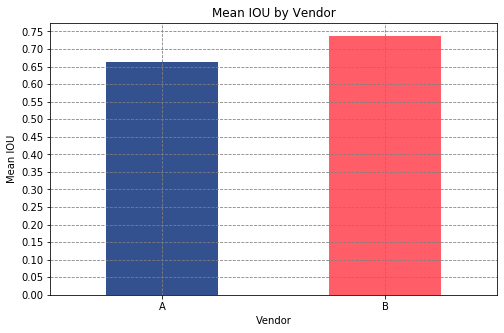

In [108]:
df.groupby("Vendor")["IOU_MEAN"].mean().plot.bar(color=colors)
# -------------------------------------------------------------- #
plt.ylabel("Mean IOU")
plt.xticks(rotation='horizontal')
plt.yticks(np.arange(0, df.groupby("Vendor")["IOU_MEAN"].mean().max()+0.05, .05))
plt.title("Mean IOU by Vendor")
plt.grid()
plt.savefig(os.path.join(save_dir, 'iou_vendor.png'), bbox_inches='tight', dpi=160)

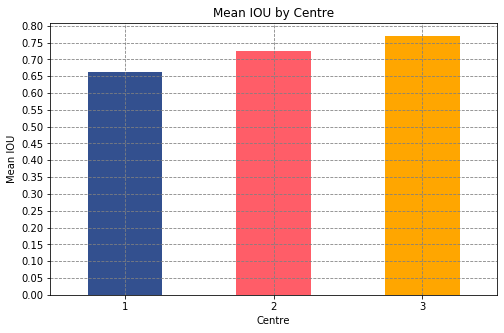

In [109]:
df.groupby("Centre")["IOU_MEAN"].mean().plot.bar(color=colors)
# -------------------------------------------------------------- #
plt.ylabel("Mean IOU")
plt.xticks(rotation='horizontal')
plt.yticks(np.arange(0, df.groupby("Centre")["IOU_MEAN"].mean().max()+0.05, .05))
plt.title("Mean IOU by Centre")
plt.grid()
plt.savefig(os.path.join(save_dir, 'iou_centre.png'), bbox_inches='tight', dpi=160)

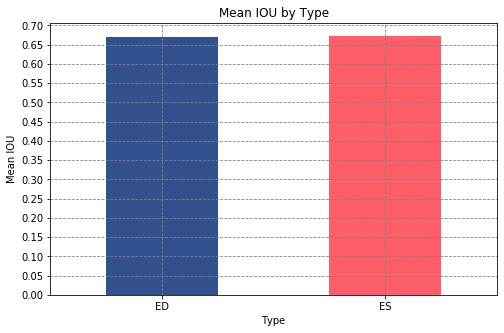

In [110]:
bars = df.groupby("Type")["IOU_MEAN"].mean().plot.bar(color=colors)
# ------------------------------------------------------------------- #
plt.ylabel("Mean IOU")
plt.xticks(rotation='horizontal')
plt.yticks(np.arange(0, df.groupby("Type")["IOU_MEAN"].mean().max()+0.05, .05))
plt.title("Mean IOU by Type")
plt.grid()
plt.savefig(os.path.join(save_dir, 'iou_type.png'), bbox_inches='tight', dpi=160)

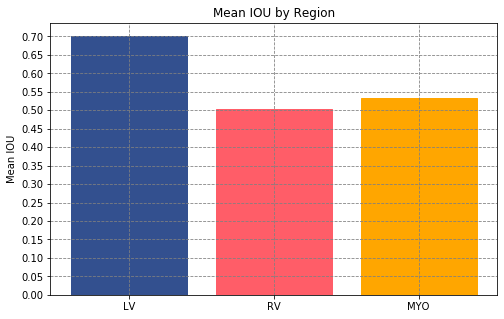

In [111]:
iou_lv = df["IOU_LV"][df["IOU_LV"]!=-1].mean()
iou_rv = df["IOU_RV"][df["IOU_RV"]!=-1].mean()
iou_myo = df["IOU_MYO"][df["IOU_MYO"]!=-1].mean()


height = [iou_lv, iou_rv, iou_myo]
bars = ('LV', 'RV', 'MYO')
y_pos = np.arange(len(bars))
 
# Create bars
barplot = plt.bar(y_pos, height)
barplot[0].set_color(colors[0])
barplot[1].set_color(colors[1])
barplot[2].set_color(colors[2])

plt.xticks(y_pos, bars)


# ------------------------------------------------------------------- #
plt.ylabel("Mean IOU")
plt.xticks(rotation='horizontal')
plt.yticks(np.arange(0, df.groupby("Type")["IOU_MEAN"].mean().max()+0.05, .05))
plt.title("Mean IOU by Region")
plt.grid()
plt.savefig(os.path.join(save_dir, 'iou_region.png'), bbox_inches='tight', dpi=160)

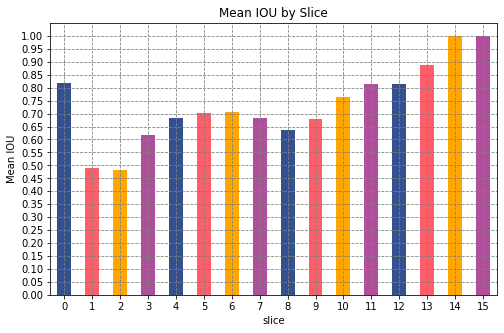

In [112]:
df.groupby("slice")["IOU_MEAN"].mean().plot.bar(color=colors)
# -------------------------------------------------------------- #
plt.ylabel("Mean IOU")
plt.xticks(rotation='horizontal')
plt.yticks(np.arange(0, df.groupby("slice")["IOU_MEAN"].mean().max()+0.05, .05))
plt.title("Mean IOU by Slice")
plt.grid()
plt.savefig(os.path.join(save_dir, 'iou_slice.png'), bbox_inches='tight', dpi=160)

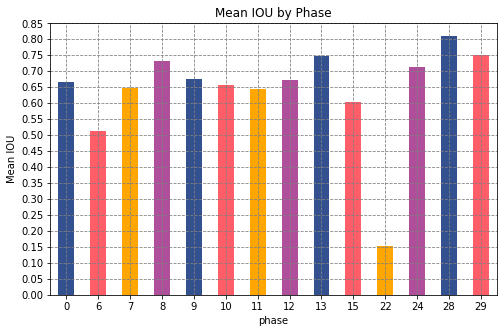

In [113]:
df.groupby("phase")["IOU_MEAN"].mean().plot.bar(color=colors)
# -------------------------------------------------------------- #
plt.ylabel("Mean IOU")
plt.xticks(rotation='horizontal')
plt.yticks(np.arange(0, df.groupby("phase")["IOU_MEAN"].mean().max()+0.05, .05))
plt.title("Mean IOU by Phase")
plt.grid()
plt.savefig(os.path.join(save_dir, 'iou_phase.png'), bbox_inches='tight', dpi=160)